# Case Study
## Forecasting stock data using machine learning

## Loading YahooFinance Dataset
Pandas web data reader is an extension of pandas library to communicate with most updated financial data.
We will extract Apple Stocks Price using the following codes:

In [ ]:
# !pip install --upgrade pandas
# !pip install --upgrade pandas-datareader

In [ ]:
import sys
import pandas as pd
import datetime

from pandas import Series, DataFrame
import pandas_datareader.data as web

start = datetime.datetime(2010, 1, 1)
end = datetime.datetime.now()

#df = pd.read_csv('AAPL.csv')

df = web.DataReader("AAPL", 'yahoo', start, end)
df.tail()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2021-12-10,179.630005,174.690002,175.210007,179.449997,115228100.0,179.449997
2021-12-13,182.130005,175.529999,181.119995,175.740005,153237000.0,175.740005
2021-12-14,177.740005,172.210007,175.250000,174.330002,139380400.0,174.330002
2021-12-15,179.500000,172.309998,175.110001,179.300003,130687600.0,179.300003
2021-12-16,181.139999,174.250000,179.279999,174.839996,57281632.0,174.839996


In [ ]:
df.shape

(3011, 6)

## Exploring the data

In [ ]:
close_px = df['Adj Close']
mavg = close_px.rolling(window=100).mean()
mavg.tail(10)

Date
2021-12-03    148.967088
2021-12-06    149.139870
2021-12-07    149.392090
2021-12-08    149.722594
2021-12-09    150.011007
2021-12-10    150.355798
2021-12-13    150.649530
2021-12-14    150.911615
2021-12-15    151.219112
2021-12-16    151.504143
Name: Adj Close, dtype: float64

## Exploring Rolling Mean and Return Rate of Stocks
In this analysis, we analyse stocks using two key measurements: Rolling Mean and Return Rate.

### Rolling Mean (Moving Average) — to determine trend
Rolling mean/Moving Average (MA) smooths out price data by creating a constantly updated average price. This is useful to cut down “noise” in our price chart. Furthermore, this Moving Average could act as “Resistance” meaning from the downtrend and uptrend of stocks you could expect it will follow the trend and less likely to deviate outside its resistance point.

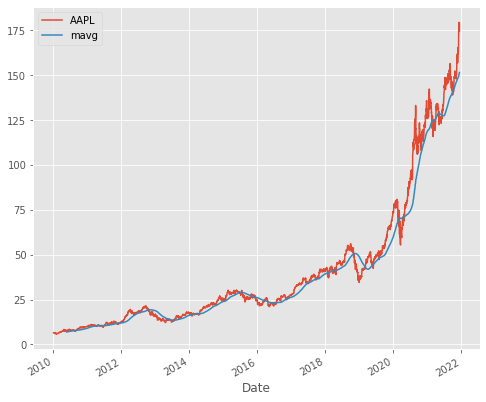

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import style

# Adjusting the size of matplotlib
import matplotlib as mpl
mpl.rc('figure', figsize=(8, 7))
mpl.__version__

# Adjusting the style of matplotlib
style.use('ggplot')

close_px.plot(label='AAPL')
mavg.plot(label='mavg')
plt.legend()

## Predicting the stocks price

To predict the return of the stocks in the next period - Prediction analysis

* Simple Linear Analysis
* Quadratic Linear Analysis (QDA)
* K Nearest Neighbor (KNN)

But first, extracting the necessary columns first from df:

* Adj Close
* Adj Volume
* High Low Percentage
* Percent Change

In [ ]:
dfreg = df.loc[:,['Adj Close','Volume']]
dfreg['HL_PCT'] = (df['High'] - df['Low']) / df['Close'] * 100.0
dfreg['PCT_change'] = (df['Close'] - df['Open']) / df['Open'] * 100.0
dfreg.head()

,Adj Close,Volume,HL_PCT,PCT_change
Date,,,,
2010-01-04,6.553024,493729600.0,0.990606,0.271752
2010-01-05,6.564355,601904800.0,1.091526,-0.102519
2010-01-06,6.459940,552160000.0,2.123529,-1.590632
2010-01-07,6.447999,477131200.0,1.400900,-0.552545
2010-01-08,6.490867,447610800.0,1.386917,0.798858


## Pre-processing & Cross Validation
Lets clean and process the data using the following steps before putting them into the prediction models:

* Drop missing value
* Separating the label here, we want to predict the AdjClose
* Scale the X so that everyone can have the same distribution for linear regression
* Finally We want to find Data Series of late X and early X (train) for model generation and evaluation
* Separate label and identify it as y
* Separation of training and testing of model by cross validation train test split
* Please refer the preparation codes below.

In [ ]:
A=[1,2,3,4,5,6,7,8,9,10]
A'=[1,2,4,5,6,7,8,10]  ----> training
A''=[3,9] ----> testing


In [ ]:
import math
import numpy as np
from sklearn import preprocessing

# Drop missing value
dfreg.fillna(value=-99999, inplace=True)

# We want to separate 1 percent of the data to forecast
forecast_out = int(math.ceil(0.01 * len(dfreg)))

# Separating the label here, we want to predict the AdjClose
forecast_col = 'Adj Close'
dfreg['label'] = dfreg[forecast_col].shift(-forecast_out)
X = np.array(dfreg.drop(['label'], 1))

# Scale the X so that everyone can have the same distribution for linear regression
X = preprocessing.scale(X)

# Finally We want to find Data Series of late X and early X (train) for model generation and evaluation
X_lately = X[-forecast_out:]
X = X[:-forecast_out]

# Separate label and identify it as y
y = np.array(dfreg['label'])
y = y[:-forecast_out]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  


In [ ]:
X = [[0], [1], [2], [3]]
y = [0, 0, 1, 1]
from sklearn.neighbors import KNeighborsRegressor
neigh = KNeighborsRegressor(n_neighbors=2)
neigh.fit(X, y)
xx=neigh.predict([[-1]])
print(neigh.predict([[-1]]))
print(type(xx[0]))

[0.]
<class 'numpy.float64'>


### Load multiple libraries related to models

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor

from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

## Linear Regression, Quadratic Discriminant Analysis and K Nearest Neighbor (KNN)

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=42)

# Linear regression
clfreg = LinearRegression(n_jobs=-1)
clfreg.fit(X_train, y_train)
# Quadratic Regression 2
clfpoly2 = make_pipeline(PolynomialFeatures(2), Ridge())
clfpoly2.fit(X_train, y_train)

# Quadratic Regression 3
clfpoly3 = make_pipeline(PolynomialFeatures(3), Ridge())
clfpoly3.fit(X_train, y_train)

# KNN Regression
clfknn = KNeighborsRegressor(n_neighbors=2)
clfknn.fit(X_train, y_train)

KNeighborsRegressor(n_neighbors=2)

### Evaluation

A simple quick and dirty way to evaluate is to use the score method in each trained model. The score method finds the mean accuracy of self.predict(X) with y of the test data set

In [ ]:
confidencereg = clfreg.score(X_test, y_test)
confidencepoly2 = clfpoly2.score(X_test,y_test)
confidencepoly3 = clfpoly3.score(X_test,y_test)
confidenceknn = clfknn.score(X_test, y_test)

In [ ]:
print("# results")
print('The linear regression confidence is {}'.format(confidencereg))
print('The quadratic regression 2 confidence is {}'.format(confidencepoly2))
print('The quadratic regression 3 confidence is {}'.format(confidencepoly3))
print('The KNN confidence is {}'.format(confidenceknn))

# results
The linear regression confidence is 0.9811546538009267
The quadratic regression 2 confidence is 0.980402816032991
The quadratic regression 3 confidence is 0.9805766312538187
The KNN confidence is 0.970674786655336


Accuracy score (>0.95) for the above models is almost the same

Lets go ahead and do some forecasting

In [ ]:
forecast_set = clfreg.predict(X_lately)
dfreg['Forecast'] = np.nan
forecast_set

array([157.27488243, 156.80052695, 157.34267474, 156.52264554,
       156.83992781, 153.9151317 , 153.87023117, 155.89158384,
       156.00352514, 156.99073411, 159.41923165, 163.78603437,
       166.68221819, 167.30413003, 167.75733838, 168.31421359,
       163.08901282, 166.54018955, 171.4128509 , 171.1954713 ,
       169.85050577, 168.19643239, 171.74640849, 177.78102733,
       181.74818329, 181.4040637 , 186.24981749, 182.64229133,
       181.07294795, 186.01662439, 181.79608978])

## Plotting the Prediction

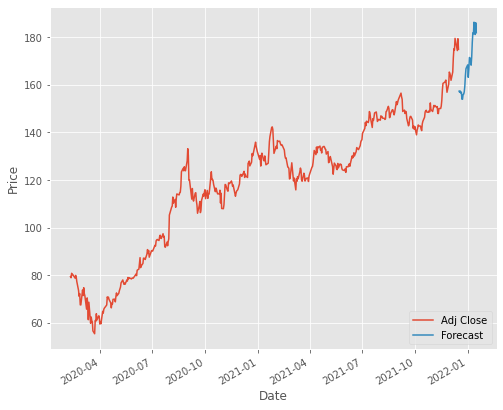

In [ ]:
last_date = dfreg.iloc[-1].name
last_unix = last_date
next_unix = last_unix + datetime.timedelta(days=1)

for i in forecast_set:
    next_date = next_unix
    next_unix += datetime.timedelta(days=1)
    dfreg.loc[next_date] = [np.nan for _ in range(len(dfreg.columns)-1)]+[i]
dfreg['Adj Close'].tail(500).plot()
dfreg['Forecast'].tail(500).plot()
plt.legend(loc=4)
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()